# 04_calibration

## Notebook Purpose
- Calibrate purchase probabilities using saved predictions only (prevents leakage/omission)
- Fit Platt scaling and Isotonic regression on VALID; select best by VALID logloss
- Apply calibration to TEST and run file-based sanity checks (must change + mean close to base rate)
- Save calibrated predictions to:
  - `artifacts/predictions/predictions_valid_calibrated.csv`
  - `artifacts/predictions/predictions_test_calibrated.csv`
  (includes both `p_cal_platt` and `p_cal_isotonic`, plus canonical `p_cal`)
- Save calibration metrics and reliability tables to `artifacts/metrics/` and `artifacts/reports/`

## Context
- Shared inputs/outputs and execution conventions are documented in the project README.

In [24]:
# ============ Common PATH (local only) ============
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\seony\Desktop\personal_project\purchase_prediction")

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
MODELS_DIR = ARTIFACTS_DIR / "models"
PRED_DIR = ARTIFACTS_DIR / "predictions"
REPORTS_DIR = ARTIFACTS_DIR / "reports"
METRICS_DIR = ARTIFACTS_DIR / "metrics"
FIGURES_DIR = ARTIFACTS_DIR / "figures"

for d in [RAW_DIR, PROCESSED_DIR, MODELS_DIR, PRED_DIR, REPORTS_DIR, METRICS_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PRED_DIR:", PRED_DIR)
print("REPORTS_DIR:", REPORTS_DIR)
print("METRICS_DIR:", METRICS_DIR)
print("FIGURES_DIR:", FIGURES_DIR)


PROJECT_ROOT: C:\Users\seony\Desktop\personal_project\purchase_prediction
PRED_DIR: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\predictions
REPORTS_DIR: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports
METRICS_DIR: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\metrics
FIGURES_DIR: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\figures


In [25]:
# ============ Imports ============
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss, brier_score_loss

import matplotlib.pyplot as plt


In [26]:
# ============ Inputs / outputs (fixed filenames) ============
PRED_VALID_RAW = PRED_DIR / "predictions_valid_raw.csv"
PRED_TEST_RAW  = PRED_DIR / "predictions_test_raw.csv"

PRED_VALID_CAL = PRED_DIR / "predictions_valid_calibrated.csv"
PRED_TEST_CAL  = PRED_DIR / "predictions_test_calibrated.csv"

CAL_METRICS_VALID_OUT = METRICS_DIR / "calibration_metrics_valid.csv"
CAL_METRICS_TEST_OUT  = METRICS_DIR / "calibration_metrics_test.csv"

RELIABILITY_VALID_RAW_OUT = REPORTS_DIR / "reliability_table_valid_raw.csv"
RELIABILITY_VALID_CAL_OUT = REPORTS_DIR / "reliability_table_valid_calibrated.csv"
RELIABILITY_TEST_RAW_OUT  = REPORTS_DIR / "reliability_table_test_raw.csv"
RELIABILITY_TEST_CAL_OUT  = REPORTS_DIR / "reliability_table_test_calibrated.csv"

CAL_CURVE_FIG_OUT = FIGURES_DIR / "calibration_curve.png"

print("PRED_VALID_RAW:", PRED_VALID_RAW, "| exists:", PRED_VALID_RAW.exists())
print("PRED_TEST_RAW :", PRED_TEST_RAW,  "| exists:", PRED_TEST_RAW.exists())


PRED_VALID_RAW: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\predictions\predictions_valid_raw.csv | exists: True
PRED_TEST_RAW : C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\predictions\predictions_test_raw.csv | exists: True


In [27]:
# ============ Load saved predictions (MUST) ============
valid = pd.read_csv(PRED_VALID_RAW)
test  = pd.read_csv(PRED_TEST_RAW)

required_cols = {"user_id", "cutoff", "y_purchase", "p_hat"}
for df_, name in [(valid, "valid"), (test, "test")]:
    if not required_cols.issubset(df_.columns):
        raise ValueError(f"{name} missing required columns: {sorted(required_cols)}")

# Ensure strict binary labels
valid["y_purchase"] = (pd.to_numeric(valid["y_purchase"], errors="coerce").fillna(0) > 0).astype("int8")
test["y_purchase"]  = (pd.to_numeric(test["y_purchase"],  errors="coerce").fillna(0) > 0).astype("int8")

y_valid = valid["y_purchase"].to_numpy()
p_valid = valid["p_hat"].astype(float).to_numpy()

y_test = test["y_purchase"].to_numpy()
p_test = test["p_hat"].astype(float).to_numpy()

print("Valid base_rate:", float(y_valid.mean()), "| p_hat mean:", float(np.mean(p_valid)))
print("Test  base_rate:", float(y_test.mean()),  "| p_hat mean:", float(np.mean(p_test)))


Valid base_rate: 0.0020656489042378077 | p_hat mean: 0.2852957562271206
Test  base_rate: 0.0019760815094101002 | p_hat mean: 0.2843986626012898


In [28]:
# ============ Helpers ============
def clip_prob(p: np.ndarray, eps: float = 1e-15) -> np.ndarray:
    return np.clip(p, eps, 1 - eps)

def safe_logloss(y: np.ndarray, p: np.ndarray) -> float:
    return float(log_loss(y, clip_prob(p)))

def brier(y: np.ndarray, p: np.ndarray) -> float:
    return float(brier_score_loss(y, clip_prob(p)))

def reliability_table(y_true: np.ndarray, p: np.ndarray, n_bins: int = 20) -> pd.DataFrame:
    # Fixed-width bins in [0, 1]
    p = np.clip(np.asarray(p, dtype=float), 0.0, 1.0)
    y_true = np.asarray(y_true, dtype=int)

    edges = np.linspace(0.0, 1.0, n_bins + 1)
    rows = []

    for i in range(n_bins):
        lo, hi = edges[i], edges[i + 1]
        if i < n_bins - 1:
            m = (p >= lo) & (p < hi)
        else:
            m = (p >= lo) & (p <= hi)

        n = int(m.sum())
        if n == 0:
            rows.append({
                "bin": i + 1,
                "n": 0,
                "y_rate": np.nan,
                "p_mean": np.nan,
                "p_min": np.nan,
                "p_max": np.nan,
            })
            continue

        rows.append({
            "bin": i + 1,
            "n": n,
            "y_rate": float(y_true[m].mean()),
            "p_mean": float(p[m].mean()),
            "p_min": float(p[m].min()),
            "p_max": float(p[m].max()),
        })

    return pd.DataFrame(rows)


def calibration_metrics(y: np.ndarray, p: np.ndarray, label: str) -> dict:
    p = clip_prob(p)
    return {
        "method": label,
        "base_rate": float(np.mean(y)),
        "logloss": safe_logloss(y, p),
        "brier": brier(y, p),
        "p_mean": float(np.mean(p)),
        "p_p99": float(np.quantile(p, 0.99)),
        "p_max": float(np.max(p)),
    }


In [29]:
# ============ Fit calibrators on VALID only (saved predictions) ============
eps = 1e-12

# Platt scaling: logistic regression on logit(p_hat)
p_valid_c = np.clip(p_valid, eps, 1 - eps)
p_test_c  = np.clip(p_test,  eps, 1 - eps)

logit_valid = np.log(p_valid_c / (1 - p_valid_c))
logit_test  = np.log(p_test_c  / (1 - p_test_c))

platt = LogisticRegression(solver="liblinear", max_iter=2000, random_state=42)
platt.fit(logit_valid.reshape(-1, 1), y_valid)
p_valid_platt = platt.predict_proba(logit_valid.reshape(-1, 1))[:, 1]
p_test_platt  = platt.predict_proba(logit_test.reshape(-1, 1))[:, 1]

# Isotonic regression on p_hat
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(p_valid, y_valid)
p_valid_iso = iso.transform(p_valid)
p_test_iso  = iso.transform(p_test)

# Select by VALID logloss
valid_ll_platt = safe_logloss(y_valid, p_valid_platt)
valid_ll_iso   = safe_logloss(y_valid, p_valid_iso)

best_method = "isotonic" if valid_ll_iso <= valid_ll_platt else "platt"
p_valid_cal = p_valid_iso if best_method == "isotonic" else p_valid_platt
p_test_cal  = p_test_iso  if best_method == "isotonic" else p_test_platt

print("VALID logloss - raw:", safe_logloss(y_valid, p_valid))
print("VALID logloss - platt:", float(valid_ll_platt))
print("VALID logloss - isotonic:", float(valid_ll_iso))
print("Best method:", best_method)


VALID logloss - raw: 0.41321122115811587
VALID logloss - platt: 0.011697015131499412
VALID logloss - isotonic: 0.01159013912078466
Best method: isotonic


In [31]:
# ============ Save calibrated predictions ============
valid_cal = valid.copy()
test_cal  = test.copy()

# Store both calibrated probabilities
valid_cal["p_cal_platt"] = p_valid_platt
valid_cal["p_cal_isotonic"] = p_valid_iso
test_cal["p_cal_platt"]  = p_test_platt
test_cal["p_cal_isotonic"]  = p_test_iso

# Choose best by VALID logloss (keep your existing selection rule)
best_method = "isotonic" if valid_ll_iso <= valid_ll_platt else "platt"
valid_cal["p_cal_method"] = best_method
test_cal["p_cal_method"]  = best_method

# Keep a canonical p_cal for downstream notebooks (based on best_method)
valid_cal["p_cal"] = valid_cal["p_cal_isotonic"] if best_method == "isotonic" else valid_cal["p_cal_platt"]
test_cal["p_cal"]  = test_cal["p_cal_isotonic"]  if best_method == "isotonic" else test_cal["p_cal_platt"]

# EV columns (require rev_hat)
if "rev_hat" in valid_cal.columns:
    valid_cal["ev_cal_platt"] = valid_cal["p_cal_platt"] * valid_cal["rev_hat"].astype(float)
    valid_cal["ev_cal_isotonic"] = valid_cal["p_cal_isotonic"] * valid_cal["rev_hat"].astype(float)
    valid_cal["ev_cal"] = valid_cal["p_cal"] * valid_cal["rev_hat"].astype(float)

if "rev_hat" in test_cal.columns:
    test_cal["ev_cal_platt"] = test_cal["p_cal_platt"] * test_cal["rev_hat"].astype(float)
    test_cal["ev_cal_isotonic"] = test_cal["p_cal_isotonic"] * test_cal["rev_hat"].astype(float)
    test_cal["ev_cal"] = test_cal["p_cal"] * test_cal["rev_hat"].astype(float)

valid_cal.to_csv(PRED_VALID_CAL, index=False)
test_cal.to_csv(PRED_TEST_CAL, index=False)

print("Saved:", PRED_VALID_CAL)
print("Saved:", PRED_TEST_CAL)
print("Best method:", best_method)

Saved: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\predictions\predictions_valid_calibrated.csv
Saved: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\predictions\predictions_test_calibrated.csv
Best method: isotonic


In [32]:
import pandas as pd
from sklearn.metrics import log_loss, brier_score_loss
import numpy as np

def _cal_row(split, method, y, p):
    p = np.clip(np.asarray(p, float), 1e-15, 1 - 1e-15)
    return {
        "split": split,
        "method": method,
        "base_rate": float(np.mean(y)),
        "p_mean": float(np.mean(p)),
        "p99": float(np.quantile(p, 0.99)),
        "pmax": float(np.max(p)),
        "logloss": float(log_loss(y, p)),
        "brier": float(brier_score_loss(y, p)),
    }

valid_tbl = pd.DataFrame([
    _cal_row("valid", "raw", y_valid, p_valid),
    _cal_row("valid", "platt", y_valid, p_valid_platt),
    _cal_row("valid", "isotonic", y_valid, p_valid_iso),
]).sort_values(["split","logloss"])

test_tbl = pd.DataFrame([
    _cal_row("test", "raw", y_test, p_test),
    _cal_row("test", "platt", y_test, p_test_platt),
    _cal_row("test", "isotonic", y_test, p_test_iso),
]).sort_values(["split","logloss"])

display(valid_tbl)
display(test_tbl)

,split,method,base_rate,p_mean,p99,pmax,logloss,brier
2,valid,isotonic,0.002066,0.002066,0.038259,0.232143,0.011590,0.002003
1,valid,platt,0.002066,0.002088,0.035046,0.205010,0.011697,0.002009
0,valid,raw,0.002066,0.285296,0.922994,0.985135,0.413211,0.123886


,split,method,base_rate,p_mean,p99,pmax,logloss,brier
1,test,platt,0.001976,0.002069,0.034037,0.215447,0.011574,0.001931
2,test,isotonic,0.001976,0.002043,0.038259,0.232143,0.011697,0.001932
0,test,raw,0.001976,0.284399,0.921097,0.985918,0.412595,0.123964


In [33]:
# ============ File-based sanity check (single cell) ============
import numpy as np
import pandas as pd

raw = pd.read_csv(PRED_TEST_RAW, usecols=["user_id", "cutoff", "y_purchase", "p_hat"])
cal = pd.read_csv(PRED_TEST_CAL, usecols=["user_id", "cutoff", "y_purchase", "p_cal"])

m = raw.merge(cal, on=["user_id", "cutoff", "y_purchase"], how="inner")
assert len(m) == len(raw), f"Row mismatch after merge: raw={len(raw)}, merged={len(m)}"

max_abs = float((m["p_cal"] - m["p_hat"]).abs().max())
base = float(m["y_purchase"].mean())
praw_mean = float(m["p_hat"].mean())
pcal_mean = float(m["p_cal"].mean())
ratio = (pcal_mean / base) if base > 0 else np.nan

print("Sanity max_abs_diff(test):", max_abs)
print("Sanity base_rate(test):", base)
print("Sanity p_hat_mean(test):", praw_mean)
print("Sanity p_cal_mean(test):", pcal_mean, "| ratio_to_base:", float(ratio))

assert max_abs > 0.0, "Calibration not applied to test (p_cal identical to p_hat)."
assert pcal_mean < praw_mean, "Calibration did not reduce mean probability (unexpected for overconfident p_hat)."
assert 0.3 <= ratio <= 3.0, "p_cal_mean is not close to base rate (possible bug or leakage)."

Sanity max_abs_diff(test): 0.9010270232563584
Sanity base_rate(test): 0.0019760815094101002
Sanity p_hat_mean(test): 0.2843986626012898
Sanity p_cal_mean(test): 0.0020431912374910964 | ratio_to_base: 1.0339610121148444


In [34]:
# ============ Save calibration metrics (VALID / TEST) ============
valid_metrics = pd.DataFrame([
    calibration_metrics(y_valid, p_valid, "raw"),
    calibration_metrics(y_valid, p_valid_platt, "platt"),
    calibration_metrics(y_valid, p_valid_iso, "isotonic"),
])
test_metrics = pd.DataFrame([
    calibration_metrics(y_test, p_test, "raw"),
    calibration_metrics(y_test, p_test_platt, "platt"),
    calibration_metrics(y_test, p_test_iso, "isotonic"),
])

valid_metrics.to_csv(CAL_METRICS_VALID_OUT, index=False)
test_metrics.to_csv(CAL_METRICS_TEST_OUT, index=False)

print("Saved:")
print(" -", CAL_METRICS_VALID_OUT)
print(" -", CAL_METRICS_TEST_OUT)

display(valid_metrics)
display(test_metrics)


Saved:
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\metrics\calibration_metrics_valid.csv
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\metrics\calibration_metrics_test.csv


,method,base_rate,logloss,brier,p_mean,p_p99,p_max
0,raw,0.002066,0.413211,0.123886,0.285296,0.922994,0.985135
1,platt,0.002066,0.011697,0.002009,0.002088,0.035046,0.205010
2,isotonic,0.002066,0.011590,0.002003,0.002066,0.038259,0.232143


,method,base_rate,logloss,brier,p_mean,p_p99,p_max
0,raw,0.001976,0.412595,0.123964,0.284399,0.921097,0.985918
1,platt,0.001976,0.011574,0.001931,0.002069,0.034037,0.215447
2,isotonic,0.001976,0.011697,0.001932,0.002043,0.038259,0.232143


In [35]:
# ============ Save reliability tables (raw vs calibrated(best)) ============
rel_valid_raw = reliability_table(y_valid, p_valid, n_bins=20)
rel_test_raw  = reliability_table(y_test,  p_test,  n_bins=20)

rel_valid_cal = reliability_table(y_valid, valid_cal["p_cal"].astype(float).to_numpy(), n_bins=20)
rel_test_cal  = reliability_table(y_test,  test_cal["p_cal"].astype(float).to_numpy(),  n_bins=20)

rel_valid_raw.to_csv(RELIABILITY_VALID_RAW_OUT, index=False)
rel_valid_cal.to_csv(RELIABILITY_VALID_CAL_OUT, index=False)
rel_test_raw.to_csv(RELIABILITY_TEST_RAW_OUT, index=False)
rel_test_cal.to_csv(RELIABILITY_TEST_CAL_OUT, index=False)

print("Saved:")
print(" -", RELIABILITY_VALID_RAW_OUT)
print(" -", RELIABILITY_VALID_CAL_OUT)
print(" -", RELIABILITY_TEST_RAW_OUT)
print(" -", RELIABILITY_TEST_CAL_OUT)

display(rel_valid_raw.head(10))
display(rel_valid_cal.head(10))


Saved:
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports\reliability_table_valid_raw.csv
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports\reliability_table_valid_calibrated.csv
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports\reliability_table_test_raw.csv
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports\reliability_table_test_calibrated.csv


,bin,n,y_rate,p_mean,p_min,p_max
0,1,390,0.000000,0.035291,0.017993,0.049997
1,2,19460,0.000360,0.088325,0.050089,0.099954
2,3,82355,0.000231,0.129602,0.100041,0.149975
3,4,33292,0.000571,0.168471,0.150011,0.199996
4,5,28501,0.000456,0.222258,0.200013,0.249994
5,6,20368,0.000786,0.275392,0.250077,0.299992
6,7,16934,0.000591,0.324015,0.300005,0.349994
7,8,15930,0.000816,0.374340,0.350003,0.399997
8,9,12529,0.001836,0.423271,0.400001,0.449984
9,10,8335,0.001560,0.474758,0.450029,0.499993


,bin,n,y_rate,p_mean,p_min,p_max
0,1,277639,0.001714,0.001714,0.000000,0.048913
1,2,891,0.062851,0.062851,0.054511,0.080460
2,3,261,0.118774,0.118774,0.113636,0.119816
3,4,0,NaN,NaN,NaN,NaN
4,5,56,0.232143,0.232143,0.232143,0.232143
5,6,0,NaN,NaN,NaN,NaN
6,7,0,NaN,NaN,NaN,NaN
7,8,0,NaN,NaN,NaN,NaN
8,9,0,NaN,NaN,NaN,NaN
9,10,0,NaN,NaN,NaN,NaN


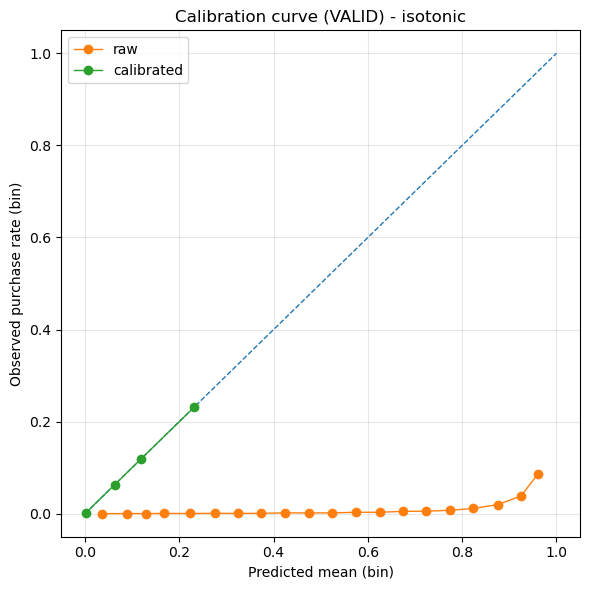

Saved: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\figures\calibration_curve.png


In [36]:
# ============ Calibration curve figure (VALID) ============
# Plot observed rate vs predicted mean by bin (raw vs calibrated)
rv = rel_valid_raw.copy()
rc = rel_valid_cal.copy()

plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

# Use only bins with n>0
rv2 = rv[rv["n"] > 0]
rc2 = rc[rc["n"] > 0]

plt.plot(rv2["p_mean"], rv2["y_rate"], marker="o", linewidth=1, label="raw")
plt.plot(rc2["p_mean"], rc2["y_rate"], marker="o", linewidth=1, label="calibrated")

plt.xlabel("Predicted mean (bin)")
plt.ylabel("Observed purchase rate (bin)")
plt.title(f"Calibration curve (VALID) - {best_method}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(CAL_CURVE_FIG_OUT, dpi=150)
plt.show()

print("Saved:", CAL_CURVE_FIG_OUT)


In [37]:
# Data check

import numpy as np
import pandas as pd

PRED_TEST_CAL = PRED_DIR / "predictions_test_calibrated.csv"
PRED_VALID_CAL = PRED_DIR / "predictions_valid_calibrated.csv"

test = pd.read_csv(PRED_TEST_CAL)
valid = pd.read_csv(PRED_VALID_CAL)

# Basic column check
print("Columns(test):", list(test.columns))
print("Columns(valid):", list(valid.columns))

# p_cal distribution (test)
p = test["p_cal"].astype(float).to_numpy()
print("\n[TEST p_cal distribution]")
print("n:", len(p))
print("mean:", float(np.mean(p)))
print("p50:", float(np.quantile(p, 0.50)))
print("p90:", float(np.quantile(p, 0.90)))
print("p95:", float(np.quantile(p, 0.95)))
print("p99:", float(np.quantile(p, 0.99)))
print("p999:", float(np.quantile(p, 0.999)))
print("max:", float(np.max(p)))

# Unique values (isotonic often produces stepwise outputs)
u = pd.Series(p).round(12).nunique()
print("unique(p_cal) rounded(12):", int(u))

# Show top 15 most frequent calibrated probability values
top_vals = (pd.Series(p).round(12).value_counts().head(15))
print("\nTop 15 most frequent p_cal values (rounded):")
print(top_vals.to_string())

# Compare raw p_hat distribution (optional, if column exists)
if "p_hat" in test.columns:
    pr = test["p_hat"].astype(float).to_numpy()
    print("\n[TEST p_hat distribution]")
    print("mean:", float(np.mean(pr)))
    print("p99:", float(np.quantile(pr, 0.99)))
    print("max:", float(np.max(pr)))


Columns(test): ['user_id', 'cutoff', 'y_purchase', 'y_revenue', 'p_hat', 'p_hat_model', 'rev_hat', 'ev', 'p_cal_platt', 'p_cal_isotonic', 'p_cal_method', 'p_cal', 'ev_cal_platt', 'ev_cal_isotonic', 'ev_cal']
Columns(valid): ['user_id', 'cutoff', 'y_purchase', 'y_revenue', 'p_hat', 'p_hat_model', 'rev_hat', 'ev', 'p_cal_platt', 'p_cal_isotonic', 'p_cal_method', 'p_cal', 'ev_cal_platt', 'ev_cal_isotonic', 'ev_cal']

[TEST p_cal distribution]
n: 253026
mean: 0.0020431912374910964
p50: 0.0005670287692491
p90: 0.0030877812086457
p95: 0.0054829185997469
p99: 0.0382585751978891
p999: 0.1136363636363636
max: 0.2321428571428571
unique(p_cal) rounded(12): 59

Top 15 most frequent p_cal values (rounded):
0.000209    48798
0.000567    29583
0.000278    27165
0.000413    24488
0.000634    23409
0.000346    18422
0.000943    18358
0.001801    16559
0.005483     9286
0.000597     7269
0.001908     6141
0.003088     4197
0.012435     2780
0.025155     2609
0.004598     2421

[TEST p_hat distribution]
